Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) 2221_1
	 (2) ID2223lab

Enter project to access: 2

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/4264
Connected. Call `.close()` to terminate connection gracefully.


Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/4264/models/tita_modal/8


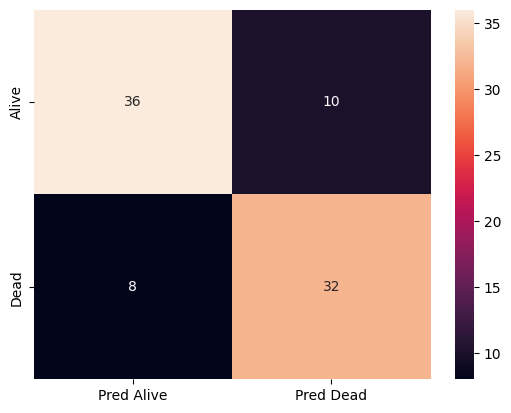

In [23]:
import os
import modal

LOCAL=True

if LOCAL == False:
   stub = modal.Stub()
   image = modal.Image.debian_slim().apt_install(["libgomp1"]).pip_install(["hopsworks", "seaborn", "joblib", "scikit-learn"])

   @stub.function(image=image, schedule=modal.Period(days=1), secret=modal.Secret.from_name("HOPSWORKS_API_KEY"))
   def f():
       g()


def g():
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import sklearn.naive_bayes as sk_bayes

    # You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
    project = hopsworks.login()
    # fs is a reference to the Hopsworks Feature Store
    fs = project.get_feature_store()

    # The feature view is the input set of features for your model. The features can come from different feature groups.    
    # You can select features from different feature groups and join them together to create a feature view
    try: 
        feature_view = fs.get_feature_view(name="tita_modal", version=1)
    except:
        iris_fg = fs.get_feature_group(name="tita_modal", version=1)
        query = iris_fg.select_all()
        feature_view = fs.create_feature_view(name="tita_modal",
                                              version=1,
                                              description="Read from tita dataset",
                                              labels=["survived"],
                                              query=query)    

    # You can read training data, randomly split into train/test sets of features (X) and labels (y)        
    X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

    # Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
    model = sk_bayes.BernoulliNB(alpha=1.0,binarize=0.0,fit_prior=True,class_prior=None)
    model.fit(X_train, y_train.values.ravel())

    # Evaluate model performance using the features from the test set (X_test)
    y_pred = model.predict(X_test)

    # Compare predictions (y_pred) with the labels in the test set (y_test)
    metrics = classification_report(y_test, y_pred, output_dict=True)
    results = confusion_matrix(y_test, y_pred)
    
    # Create the confusion matrix as a figure, we will later store it as a PNG image file
    df_cm = pd.DataFrame(results, ['Alive', 'Dead'],
                         ['Pred Alive', 'Pred Dead'])
    cm = sns.heatmap(df_cm, annot=True)
    fig = cm.get_figure()

    # We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
    mr = project.get_model_registry()
    
    # The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
    model_dir="tita_model"
    if os.path.isdir(model_dir) == False:
        os.mkdir(model_dir)

    # Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
    joblib.dump(model, model_dir + "/tita_model.pkl")
    fig.savefig(model_dir + "/confusion_matrix.png")    


    # Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
    input_schema = Schema(X_train)
    output_schema = Schema(y_train)
    model_schema = ModelSchema(input_schema, output_schema)

    # Create an entry in the model registry that includes the model's name, desc, metrics
    tita_model = mr.python.create_model(
        name="tita_modal", 
        metrics={"accuracy" : metrics['accuracy']},
        model_schema=model_schema,
        description="Tita Predictor"
    )
    
    # Upload the model to the model registry, including all files in 'model_dir'
    tita_model.save(model_dir)
    
if __name__ == "__main__":
    if LOCAL == True :
        g()
    else:
        with stub.run():
            f()


## 